# Piecewise Exact Method

### Force Segmentation

The primary source of error with the piecewise exact step-by-step method is the difference between the actual force experienced by the structure and the piecewise representation of that force used in the simulation. In this lecture we'll explore the influence force segmentation has on the numerically calculated response.   

We'll start by importing some dependencies and establishing some constants:

In [1]:
# DEPENDENCIES
import math
import numpy as np
import matplotlib.pyplot as plt

# SYSTEM CONSTANTS
m = 1000 #(kg) Mass
k = 20000 #(N/m) Stiffness
xi = 0.05 # Damping ratio 
P = 750 # (N) Force magnitude
f = 1 # (Hz) Forcing frequency
pi = math.pi
omega_n = math.sqrt(k/m) #(rads/sec) Undamped natural frequency
f_n = omega_n/(2*pi) #(Hz) Undamped natural frequency
omega_d = omega_n*math.sqrt(1-xi**2) #Damped natural frequency
omega = 2*pi*f #(rads/sec) Forcing frequency
beta = omega/omega_n # Frequency ratio

Consider a 'benchmark' forcing function generated from a sine wave:

In [2]:
# BENCHMARK FORCE VECTOR
tmax = 30 #(sec) The max time
delta_t = 0.005 #(sec) The timestep
nPoints = tmax/delta_t #Number of equally spaced data points
t = np.linspace(0,tmax, int(nPoints)) # Time vector
F_sine = P*np.sin(omega*t) #Force vector

We can plot the first second of the signal.

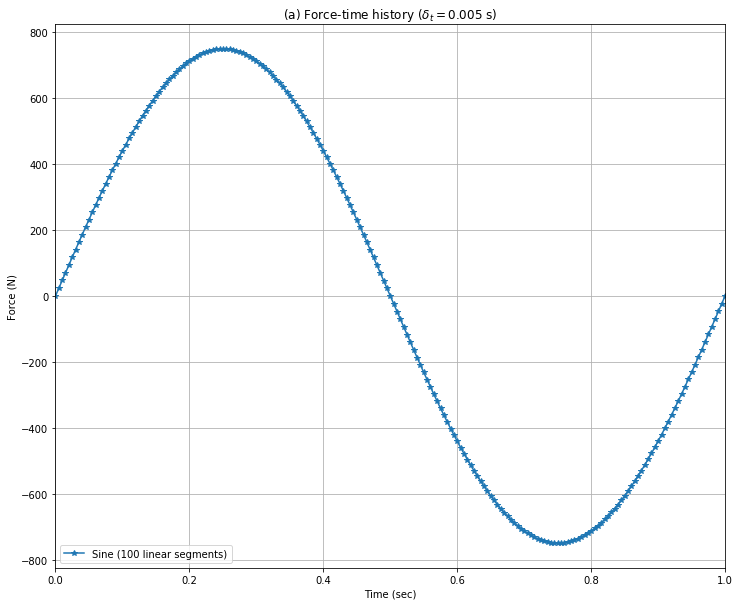

In [3]:
#Plotting 
fig, axes = plt.subplots(figsize=(12,10)) 
axes.plot(t,F_sine,'-*', label='Sine (100 linear segments)')
axes.set_xlabel('Time (sec)')
axes.set_ylabel('Force (N)')
axes.set_title('(a) Force-time history ($\delta_t = 0.005$ s)')
axes.legend(loc='lower left')
axes.set_xlim([0,1])
axes.grid()

Assume this is a naturally occuring force signal.

Now imagine we are only able to sample this force signal at say, 4, 8, 20 and 40 Hz. Consider the first of these cases, 4 samples per second:

![title](img/image_2.png)

**Note that the timestep remains constant in each case,** i.e. force values between the sampling points are generated by linearly interpolating between sample points.

We now need to generate a simple algorithm to sample the forcing function and generate the force values between sample points.

### Define a function to generate piecewise linear force vectors

In [4]:
def generateForce(nSegs, tmax, P):
    """
    nSegs: the number of linear segments in a single cycle
    tmax: the length of the force record to be sampled
    P: the magnitude of the sine wave being sampled    
    """
    nSegments = nSegs*tmax  #[4, 8, 20, 40]Number of segments forcing function is divided into
    sp = np.linspace(0, tmax, nSegments+1,endpoint=True) #Sampling times
    f_sp = P*np.sin(omega*sp) #Sample points (force values at sample times)   
   
    #Generate the time and force vectors (sampling points and infil data points between)
    F = np.array([])
    T = np.array([])
    for n in np.arange(nSegments):   

        if n==nSegments-1:
            forceVector = np.linspace(f_sp[n],f_sp[n+1],int(nPoints/nSegments),endpoint=True)
            timeVector = np.linspace(sp[n],sp[n+1],int(nPoints/nSegments),endpoint=True)           
        else:
            forceVector = np.linspace(f_sp[n],f_sp[n+1],int(nPoints/nSegments),endpoint=False)
            timeVector = np.linspace(sp[n],sp[n+1],int(nPoints/nSegments),endpoint=False)
            
        F = np.append(F, forceVector, axis=0)
        T = np.append(T, timeVector, axis=0)

    return [T, F, sp, f_sp]

### Call function to generate piecewise linear force vectors

In [5]:
T4,F4, sp4, f_sp4 = generateForce(4, tmax, P) #Time and force vectors when sampling at 4Hz
T8,F8, sp8, f_sp8 = generateForce(8, tmax, P) #Time and force vectors when sampling at 8Hz
T20,F20, sp20, f_sp20 = generateForce(20, tmax, P) #Time and force vectors when sampling at 20Hz
T40,F40, sp40, f_sp40 = generateForce(40, tmax, P) #Time and force vectors when sampling at 40Hz

### Plot piecewise linear force vectors

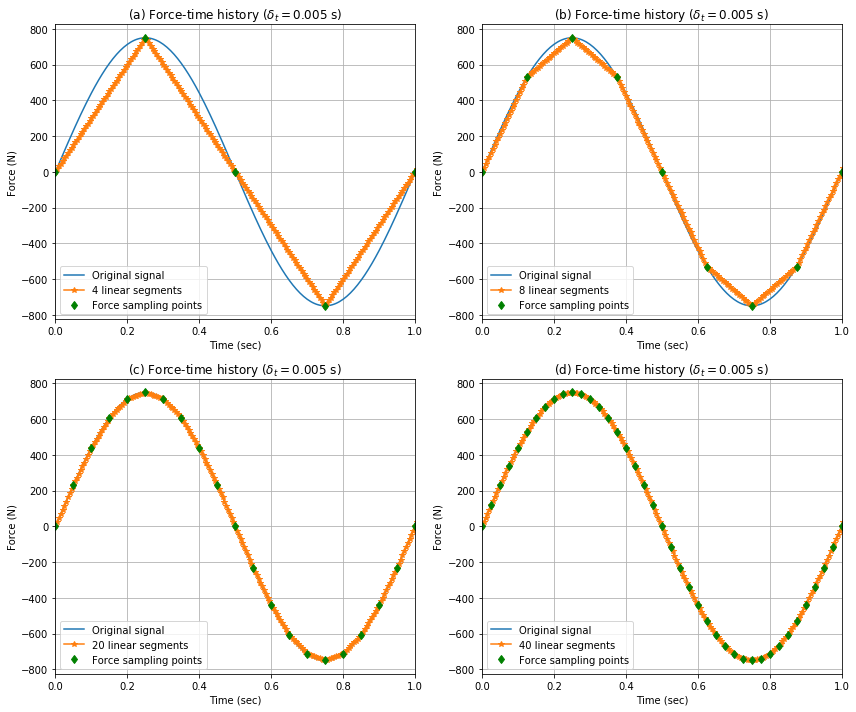

In [6]:
#Plotting 
fig, axes = plt.subplots(figsize=(12,10),nrows=2,ncols=2) 
axes[0][0].plot(t,F_sine,label='Original signal')
axes[0][0].plot(T4,F4,'-*', label='4 linear segments')
axes[0][0].plot(sp4,f_sp4,'gd', label='Force sampling points')
axes[0][0].set_xlabel('Time (sec)')
axes[0][0].set_ylabel('Force (N)')
axes[0][0].set_title('(a) Force-time history ($\delta_t = 0.005$ s)')
axes[0][0].legend(loc='lower left')
axes[0][0].set_xlim([0,1])
axes[0][0].grid()

axes[0][1].plot(t,F_sine,'-', label='Original signal')
axes[0][1].plot(T8,F8,'-*', label='8 linear segments')
axes[0][1].plot(sp8,f_sp8,'gd', label='Force sampling points')
axes[0][1].set_xlabel('Time (sec)')
axes[0][1].set_ylabel('Force (N)')
axes[0][1].set_title('(b) Force-time history ($\delta_t = 0.005$ s)')
axes[0][1].legend(loc='lower left')
axes[0][1].set_xlim([0,1])
axes[0][1].grid()

axes[1][0].plot(t,F_sine,'-', label='Original signal')
axes[1][0].plot(T20,F20,'-*', label='20 linear segments')
axes[1][0].plot(sp20,f_sp20,'gd', label='Force sampling points')
axes[1][0].set_xlabel('Time (sec)')
axes[1][0].set_ylabel('Force (N)')
axes[1][0].set_title('(c) Force-time history ($\delta_t = 0.005$ s)')
axes[1][0].legend(loc='lower left')
axes[1][0].set_xlim([0,1])
axes[1][0].grid()

axes[1][1].plot(t,F_sine,'-', label='Original signal')
axes[1][1].plot(T40,F40,'-*', label='40 linear segments')
axes[1][1].plot(sp40,f_sp40,'gd', label='Force sampling points')
axes[1][1].set_xlabel('Time (sec)')
axes[1][1].set_ylabel('Force (N)')
axes[1][1].set_title('(d) Force-time history ($\delta_t = 0.005$ s)')
axes[1][1].legend(loc='lower left')
axes[1][1].set_xlim([0,1])
axes[1][1].grid()

plt.tight_layout()

### Define a function to calculate dynamic response (from previous lecture)

In [7]:
#Define a function that takes in a time and force vector
def calculateResponse(tVector, fVector):
    nPoints = len(tVector) #Number of data points 
    
    #Constants
    A = math.e**(-xi*omega_n*delta_t)*((xi/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t)+np.cos(omega_d*delta_t))
    B = math.e**(-xi*omega_n*delta_t)*((1/omega_d*np.sin(omega_d*delta_t)))
    C = (1/k)*(((2*xi)/(omega_n*delta_t)) + math.e**(-xi*omega_n*delta_t)*((((1-2*(xi**2))/(omega_d*delta_t))-(xi/(math.sqrt(1-(xi**2)))))*math.sin(omega_d*delta_t)-(1+((2*xi)/(omega_n*delta_t)))*np.cos(omega_d*delta_t)))
    D = (1/k)*(1-((2*xi)/(omega_n*delta_t))+math.e**(-xi*omega_n*delta_t)*(((2*(xi**2)-1)/(omega_d*delta_t))*np.sin(omega_d*delta_t)+((2*xi)/(omega_n*delta_t))*np.cos(omega_d*delta_t)))

    A1 = -math.e**(-xi*omega_n*delta_t)*((omega_n/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t))
    B1 = math.e**(-xi*omega_n*delta_t)*(np.cos(omega_d*delta_t)-((xi)/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t))
    C1 =(1/k)*(-(1/delta_t)+math.e**(-xi*omega_n*delta_t)*((((omega_n)/(math.sqrt(1-(xi**2))))+((xi)/(delta_t*math.sqrt(1-(xi**2)))))*np.sin(omega_d*delta_t)+(1/delta_t)*np.cos(omega_d*delta_t)))
    D1 =(1/k)*((1/delta_t)-(math.e**(-xi*omega_n*delta_t)/delta_t)*((xi/(math.sqrt(1-(xi**2))))*np.sin(omega_d*delta_t)+np.cos(omega_d*delta_t))) 

    #INITIAL CONDITIONS
    x0=0 
    v0=0

    pos = [] #Initialise an array to hold calculated position
    vel = [] #Initialise an array to hold calculated velocity
    
    #MAIN LOOP (to 'step through' solution)
    for n, timestep in enumerate(tVector):
        #note that enumerate adds a counter to an iterable (n)
        timestep = round(timestep,3) #The current time

        #Update the force values
        if n<nPoints-1:
            Fn = fVector[n]
            Fnp1 = fVector[n+1]
        else:
            #Pickup when we're at the end of the force vector (no more +1 values)
            Fn = fVector[n]
            Fnp1 = 0
            
        #Calculate the position and velocity at the end of the timestep
        curPos = (A*x0) + (B*v0) + (C*Fn) + (D*Fnp1)
        curVel = (A1*x0) + (B1*v0)+ (C1*Fn) + (D1*Fnp1)

        #Append (save) the position and velocity into the vectors defined above
        pos.append(curPos)
        vel.append(curVel)

        #Update initial conditions for the next loop iteration     
        x0 = curPos;
        v0 = curVel;
    
    return pos #Return the calculated position out of the function     

### Call function to calculate response for different degrees of force segmentation
(Note that the simulation time-step in all cases is 0.005s)

In [8]:
Pos = calculateResponse(t,F_sine)
Pos4 = calculateResponse(T4,F4)
Pos8 = calculateResponse(T8,F8)
Pos20 = calculateResponse(T20,F20)
Pos40 = calculateResponse(T40,F40)

### Plot responses

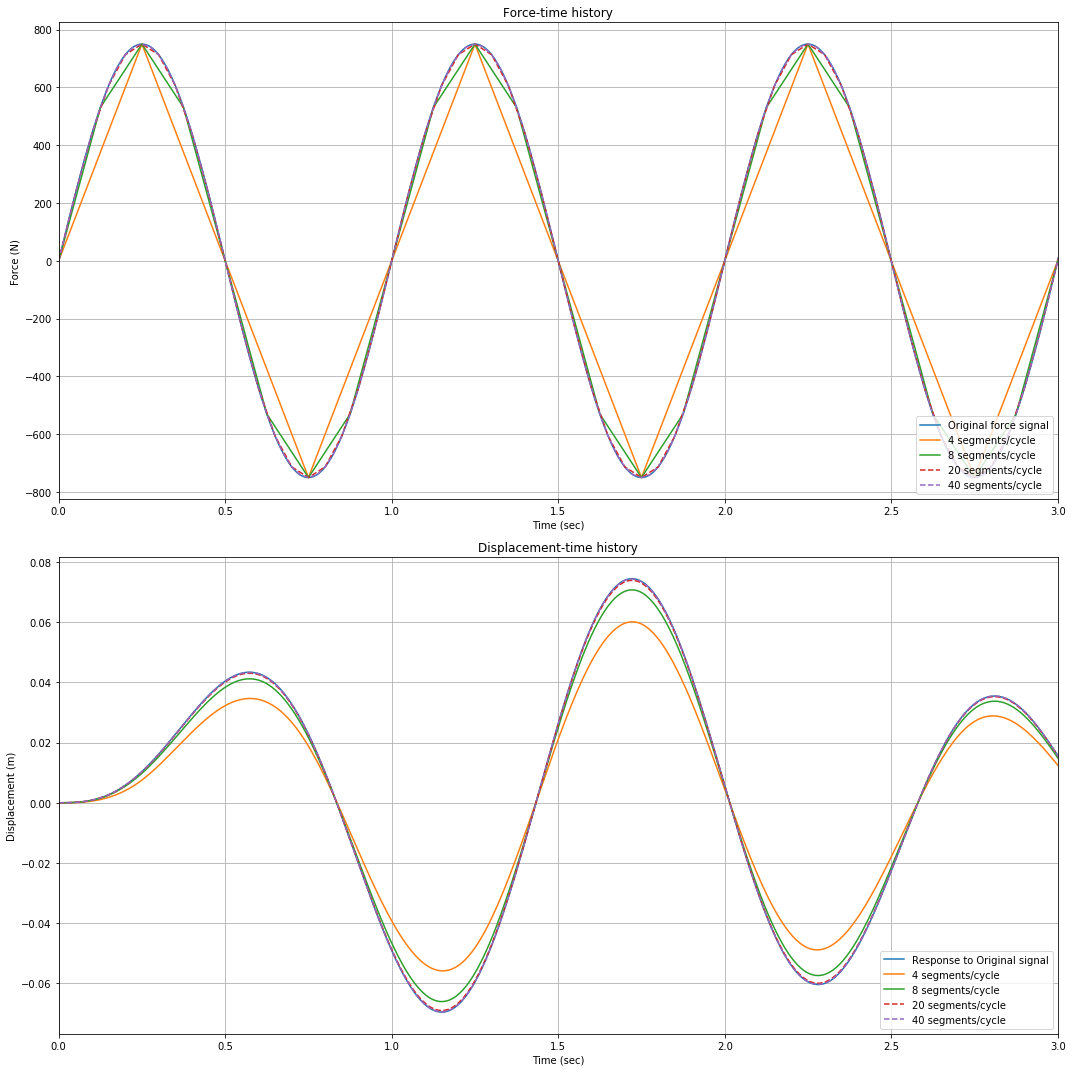

In [9]:
# Plotting Force
fig, axes = plt.subplots(figsize=(15,15),nrows=2,ncols=1) 
axes[0].plot(t,F_sine,'-', label='Original force signal')
axes[0].plot(T4,F4,'-', label='4 segments/cycle')
axes[0].plot(T8,F8,'-', label='8 segments/cycle')
axes[0].plot(T20,F20,'--', label='20 segments/cycle')
axes[0].plot(T40,F40,'--', label='40 segments/cycle')
axes[0].set_xlim([0,3])
axes[0].set_xlabel('Time (sec)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title('Force-time history')
axes[0].grid()
axes[0].legend(loc='lower right')

#Plotting Displacement
axes[1].plot(t,Pos, label='Response to Original signal')
axes[1].plot(T4,Pos4, label='4 segments/cycle')
axes[1].plot(T8,Pos8, label='8 segments/cycle')
axes[1].plot(T20,Pos20, '--',label='20 segments/cycle')
axes[1].plot(T40,Pos40, '--',label='40 segments/cycle')
axes[1].set_xlim([0,3])
axes[1].set_xlabel('Time (sec)')
axes[1].set_ylabel('Displacement (m)')
axes[1].set_title('Displacement-time history')
axes[1].grid()
axes[1].legend(loc='lower right')
plt.tight_layout()


### Some observations
<ul>
<li>We can see, as expected that the more frequently we sample the force signal, in other words the more linear segments we use to represent or 'reconstruct' it, the more accurate is the resulting dynamic behaviour.
</ul>
<ul>
<li>However, we also see that doubling the number of samples (linear segments) from 20 to 40 produces a negligible increase in response accuracy. At a particular level of segmentation we reach a point of diminishing returns.  
</ul>
<ul>
<li>It will be for you the engineer, to determine, based on a sensitivity analysis what level of segmentation you need to employ. This can be done as demonstrated above by seeking convergence in the system's dynamic behaviour. 
</ul>
<ul>
<li>Of course, with the negligible cost of computation, you may also consider not segmenting your force signal at all beyond its source sampling rate. In this example, that would mean generating $1/0.005 = 200$ samples or segments per cycle. Of course we have in fact done this, to generate the 'benchmark' response. 
</ul>